# 實驗 29：滑動窗口消融實驗

## 實驗目的
比較使用滑動窗口擴增資料與不使用滑動窗口（僅取每位患者最後一組窗口）的模型性能差異，
驗證滑動窗口方法是否能有效提升預測性能。

## 實驗設計
- **滑動窗口**：所有窗口（13,514 筆樣本，來自 6,056 位患者）
- **無滑動窗口**：每位患者僅取最後一組窗口（6,056 筆樣本）
- **交叉驗證**：兩組均使用 StratifiedGroupKFold（以 patient_id 分組）
- **模型**：10 種（LR, NB, LDA, KNN, DT, RF, XGB, LGBM, SVM, MLP）

## 與舊實驗 13 的差異
舊 Nb13 使用 StratifiedKFold（可能有資料洩漏），本實驗統一使用 StratifiedGroupKFold，
確保公平比較。

## 日期：2026-02-24

In [1]:
# 匯入套件
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import roc_auc_score, recall_score, f1_score, confusion_matrix, balanced_accuracy_score
from sklearn.base import clone
import xgboost as xgb
import lightgbm as lgb
from scipy import stats
import time

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

print("套件載入完成")

套件載入完成


In [2]:
# 載入滑動窗口資料
df_all = pd.read_csv('../../data/01_primary/SUA/processed/SUA_sliding_window.csv')
print(f"滑動窗口資料：{len(df_all):,} 筆樣本，{df_all['patient_id'].nunique():,} 位患者")
print(f"窗口起始點分佈：")
print(df_all['window_start'].value_counts().sort_index())

# 建立「無滑動窗口」版本：每位患者僅取最後一組窗口
# 最後一組窗口 = window_start 最大的那筆（最近的 3 次健檢）
df_last = df_all.loc[df_all.groupby('patient_id')['window_start'].idxmax()].reset_index(drop=True)
print(f"\n無滑動窗口資料：{len(df_last):,} 筆樣本，{df_last['patient_id'].nunique():,} 位患者")
print(f"（每位患者僅保留最後一組窗口）")

滑動窗口資料：13,514 筆樣本，6,056 位患者
窗口起始點分佈：
1    6056
2    4302
3    2526
4     591
5      35
6       4
Name: window_start, dtype: int64

無滑動窗口資料：6,056 筆樣本，6,056 位患者
（每位患者僅保留最後一組窗口）


In [3]:
# 定義特徵與目標
feature_cols = [
    'sex', 'Age',
    'FBG_Tinput1', 'TC_Tinput1', 'Cr_Tinput1', 'UA_Tinput1', 'GFR_Tinput1', 'BMI_Tinput1', 'SBP_Tinput1', 'DBP_Tinput1',
    'FBG_Tinput2', 'TC_Tinput2', 'Cr_Tinput2', 'UA_Tinput2', 'GFR_Tinput2', 'BMI_Tinput2', 'SBP_Tinput2', 'DBP_Tinput2',
    'Delta_FBG', 'Delta_TC', 'Delta_Cr', 'Delta_UA', 'Delta_GFR', 'Delta_BMI', 'Delta_SBP', 'Delta_DBP'
]

target_cols = {
    '高血壓': 'hypertension_target',
    '高血糖': 'hyperglycemia_target',
    '高血脂': 'dyslipidemia_target'
}

# 檢查兩組資料的類別分佈
print("類別分佈比較：")
print(f"{'':15} {'滑動窗口':>15} {'無滑動窗口':>15}")
for name, col in target_cols.items():
    rate_all = (df_all[col] == 2).mean() * 100
    rate_last = (df_last[col] == 2).mean() * 100
    print(f"{name:15} {rate_all:>13.2f}% {rate_last:>13.2f}%")

類別分佈比較：
                           滑動窗口           無滑動窗口
高血壓                     19.29%         22.08%
高血糖                      5.93%          6.61%
高血脂                      7.94%         11.16%


In [4]:
# 定義模型
def get_models(random_state=42):
    return {
        'LR': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=random_state),
        'NB': GaussianNB(),
        'LDA': LinearDiscriminantAnalysis(),
        'KNN': KNeighborsClassifier(n_neighbors=5, weights='uniform', n_jobs=-1),
        'DT': DecisionTreeClassifier(max_depth=10, min_samples_split=20, min_samples_leaf=10, class_weight='balanced', random_state=random_state),
        'RF': RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_split=10, class_weight='balanced', random_state=random_state, n_jobs=-1),
        'XGB': xgb.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, scale_pos_weight=5, random_state=random_state, eval_metric='logloss', verbosity=0),
        'LGBM': lgb.LGBMClassifier(n_estimators=100, max_depth=-1, num_leaves=31, learning_rate=0.1, is_unbalance=True, random_state=random_state, verbosity=-1),
        'SVM': SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=random_state),
        'MLP': MLPClassifier(hidden_layer_sizes=(64, 32, 16), activation='relu', solver='adam', learning_rate_init=0.001, max_iter=500, random_state=random_state, early_stopping=True, validation_fraction=0.1)
    }

print(f"模型數量：{len(get_models())}")
for name in get_models().keys():
    print(f"  - {name}")

模型數量：10
  - LR
  - NB
  - LDA
  - KNN
  - DT
  - RF
  - XGB
  - LGBM
  - SVM
  - MLP


In [5]:
# 評估函式
def evaluate_cv(df, feature_cols, target_col, model, n_splits=5, random_state=42):
    X = df[feature_cols]
    y = (df[target_col] == 2).astype(int)
    groups = df['patient_id']
    
    cv = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    fold_auc = []
    fold_sens = []
    fold_spec = []
    fold_f1 = []
    
    for train_idx, test_idx in cv.split(X, y, groups):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # 確認無資料洩漏
        train_p = set(groups.iloc[train_idx])
        test_p = set(groups.iloc[test_idx])
        assert len(train_p & test_p) == 0
        
        scaler = StandardScaler()
        X_train_s = scaler.fit_transform(X_train)
        X_test_s = scaler.transform(X_test)
        
        m = clone(model)
        if isinstance(m, xgb.XGBClassifier):
            m.set_params(scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum())
        
        m.fit(X_train_s, y_train)
        y_prob = m.predict_proba(X_test_s)[:, 1]
        y_pred = m.predict(X_test_s)
        
        fold_auc.append(roc_auc_score(y_test, y_prob))
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        fold_sens.append(tp / (tp + fn) if (tp + fn) > 0 else 0)
        fold_spec.append(tn / (tn + fp) if (tn + fp) > 0 else 0)
        fold_f1.append(f1_score(y_test, y_pred, zero_division=0))
    
    return {
        'auc_mean': np.mean(fold_auc), 'auc_std': np.std(fold_auc),
        'sens_mean': np.mean(fold_sens), 'spec_mean': np.mean(fold_spec),
        'f1_mean': np.mean(fold_f1),
        'auc_folds': fold_auc
    }

print("評估函式定義完成")

評估函式定義完成


In [6]:
# 執行實驗
start_time = time.time()

results = []

datasets = {
    '滑動窗口': df_all,
    '無滑動窗口': df_last
}

for ds_name, df in datasets.items():
    print(f"\n{'=' * 60}")
    print(f"{ds_name}（{len(df):,} 筆樣本）")
    print(f"{'=' * 60}")
    
    for disease_name, target_col in target_cols.items():
        print(f"\n  --- {disease_name} ---")
        models = get_models()
        
        for model_name, model in models.items():
            print(f"    {model_name}...", end=" ")
            r = evaluate_cv(df, feature_cols, target_col, model)
            
            results.append({
                '資料集': ds_name,
                '疾病': disease_name,
                '模型': model_name,
                'AUC': r['auc_mean'],
                'AUC_std': r['auc_std'],
                'Sensitivity': r['sens_mean'],
                'Specificity': r['spec_mean'],
                'F1': r['f1_mean'],
                'auc_folds': r['auc_folds']
            })
            print(f"AUC = {r['auc_mean']:.3f} ± {r['auc_std']:.3f}")

elapsed = time.time() - start_time
print(f"\n總執行時間：{elapsed:.1f} 秒")


滑動窗口（13,514 筆樣本）

  --- 高血壓 ---
    LR... AUC = 0.721 ± 0.017
    NB... AUC = 0.709 ± 0.022
    LDA... AUC = 0.720 ± 0.017
    KNN... AUC = 0.630 ± 0.018
    DT... AUC = 0.658 ± 0.012
    RF... AUC = 0.743 ± 0.013
    XGB... AUC = 0.738 ± 0.012
    LGBM... AUC = 0.730 ± 0.011
    SVM... AUC = 0.726 ± 0.011
    MLP... AUC = 0.703 ± 0.033

  --- 高血糖 ---
    LR... AUC = 0.938 ± 0.010
    NB... AUC = 0.917 ± 0.010
    LDA... AUC = 0.936 ± 0.011
    KNN... AUC = 0.782 ± 0.020
    DT... AUC = 0.835 ± 0.014
    RF... AUC = 0.932 ± 0.008
    XGB... AUC = 0.930 ± 0.014
    LGBM... AUC = 0.926 ± 0.015
    SVM... AUC = 0.919 ± 0.012
    MLP... AUC = 0.919 ± 0.021

  --- 高血脂 ---
    LR... AUC = 0.867 ± 0.012
    NB... AUC = 0.847 ± 0.015
    LDA... AUC = 0.867 ± 0.012
    KNN... AUC = 0.673 ± 0.013
    DT... AUC = 0.744 ± 0.037
    RF... AUC = 0.859 ± 0.014
    XGB... AUC = 0.857 ± 0.016
    LGBM... AUC = 0.852 ± 0.011
    SVM... AUC = 0.845 ± 0.012
    MLP... AUC = 0.742 ± 0.136

無滑動窗口（6,056 筆樣本

In [7]:
# 整理比較結果
results_df = pd.DataFrame(results)

print("=" * 90)
print("滑動窗口 vs 無滑動窗口 AUC 比較")
print("=" * 90)

model_order = ['LR', 'NB', 'LDA', 'KNN', 'DT', 'RF', 'XGB', 'LGBM', 'SVM', 'MLP']

for disease in target_cols.keys():
    print(f"\n--- {disease} ---")
    print(f"{'模型':>5}  {'滑動窗口':>18}  {'無滑動窗口':>18}  {'差異 (ΔAUC)':>12}")
    print("-" * 60)
    
    for model_name in model_order:
        r_sw = results_df[(results_df['資料集'] == '滑動窗口') & (results_df['疾病'] == disease) & (results_df['模型'] == model_name)]
        r_no = results_df[(results_df['資料集'] == '無滑動窗口') & (results_df['疾病'] == disease) & (results_df['模型'] == model_name)]
        
        if len(r_sw) > 0 and len(r_no) > 0:
            auc_sw = r_sw['AUC'].values[0]
            std_sw = r_sw['AUC_std'].values[0]
            auc_no = r_no['AUC'].values[0]
            std_no = r_no['AUC_std'].values[0]
            diff = auc_sw - auc_no
            print(f"{model_name:>5}  {auc_sw:.3f} ± {std_sw:.3f}  {auc_no:.3f} ± {std_no:.3f}  {diff:>+.3f}")

滑動窗口 vs 無滑動窗口 AUC 比較

--- 高血壓 ---
   模型                滑動窗口               無滑動窗口     差異 (ΔAUC)
------------------------------------------------------------
   LR  0.721 ± 0.017  0.728 ± 0.011  -0.007
   NB  0.709 ± 0.022  0.715 ± 0.010  -0.006
  LDA  0.720 ± 0.017  0.727 ± 0.013  -0.007
  KNN  0.630 ± 0.018  0.647 ± 0.015  -0.018
   DT  0.658 ± 0.012  0.646 ± 0.019  +0.012
   RF  0.743 ± 0.013  0.736 ± 0.013  +0.007
  XGB  0.738 ± 0.012  0.726 ± 0.016  +0.012
 LGBM  0.730 ± 0.011  0.723 ± 0.014  +0.007
  SVM  0.726 ± 0.011  0.723 ± 0.010  +0.003
  MLP  0.703 ± 0.033  0.713 ± 0.018  -0.009

--- 高血糖 ---
   模型                滑動窗口               無滑動窗口     差異 (ΔAUC)
------------------------------------------------------------
   LR  0.938 ± 0.010  0.940 ± 0.006  -0.002
   NB  0.917 ± 0.010  0.917 ± 0.015  +0.001
  LDA  0.936 ± 0.011  0.943 ± 0.005  -0.006
  KNN  0.782 ± 0.020  0.788 ± 0.015  -0.005
   DT  0.835 ± 0.014  0.836 ± 0.008  -0.001
   RF  0.932 ± 0.008  0.927 ± 0.008  +0.005
  XGB  

In [8]:
# 統計檢定：paired t-test（配對 5-fold AUC）
print("=" * 90)
print("統計檢定（Paired t-test on 5-fold AUC）")
print("=" * 90)

for disease in target_cols.keys():
    print(f"\n--- {disease} ---")
    print(f"{'模型':>5}  {'t-statistic':>12}  {'p-value':>10}  {'顯著':>6}")
    print("-" * 45)
    
    for model_name in model_order:
        r_sw = results_df[(results_df['資料集'] == '滑動窗口') & (results_df['疾病'] == disease) & (results_df['模型'] == model_name)]
        r_no = results_df[(results_df['資料集'] == '無滑動窗口') & (results_df['疾病'] == disease) & (results_df['模型'] == model_name)]
        
        if len(r_sw) > 0 and len(r_no) > 0:
            folds_sw = r_sw['auc_folds'].values[0]
            folds_no = r_no['auc_folds'].values[0]
            t_stat, p_val = stats.ttest_rel(folds_sw, folds_no)
            sig = '**' if p_val < 0.01 else ('*' if p_val < 0.05 else '')
            print(f"{model_name:>5}  {t_stat:>12.3f}  {p_val:>10.4f}  {sig:>6}")

統計檢定（Paired t-test on 5-fold AUC）

--- 高血壓 ---
   模型   t-statistic     p-value      顯著
---------------------------------------------
   LR        -0.609      0.5757        
   NB        -0.559      0.6060        
  LDA        -0.532      0.6226        
  KNN        -2.257      0.0870        
   DT         2.550      0.0633        
   RF         0.817      0.4599        
  XGB         1.278      0.2703        
 LGBM         0.728      0.5067        
  SVM         0.388      0.7177        
  MLP        -0.581      0.5924        

--- 高血糖 ---
   模型   t-statistic     p-value      顯著
---------------------------------------------
   LR        -0.376      0.7262        
   NB         0.074      0.9447        
  LDA        -1.222      0.2888        
  KNN        -0.367      0.7325        
   DT        -0.198      0.8528        
   RF         0.795      0.4710        
  XGB        -0.345      0.7477        
 LGBM        -0.679      0.5346        
  SVM         0.021      0.9844        
  MLP   

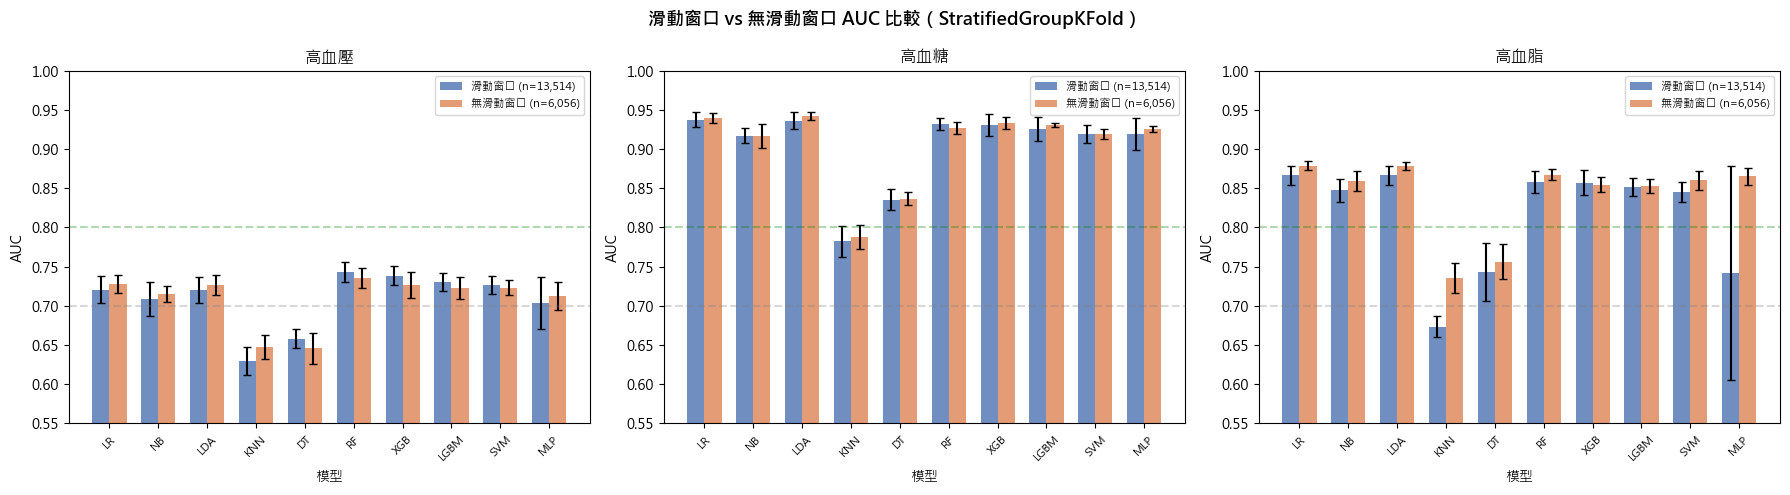

已儲存：results/sliding_window_ablation.png


In [9]:
# 視覺化：AUC 比較圖
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

diseases = list(target_cols.keys())

for idx, disease in enumerate(diseases):
    ax = axes[idx]
    
    x = np.arange(len(model_order))
    width = 0.35
    
    auc_sw = []
    std_sw = []
    auc_no = []
    std_no = []
    
    for model_name in model_order:
        r_sw = results_df[(results_df['資料集'] == '滑動窗口') & (results_df['疾病'] == disease) & (results_df['模型'] == model_name)]
        r_no = results_df[(results_df['資料集'] == '無滑動窗口') & (results_df['疾病'] == disease) & (results_df['模型'] == model_name)]
        auc_sw.append(r_sw['AUC'].values[0])
        std_sw.append(r_sw['AUC_std'].values[0])
        auc_no.append(r_no['AUC'].values[0])
        std_no.append(r_no['AUC_std'].values[0])
    
    bars1 = ax.bar(x - width/2, auc_sw, width, yerr=std_sw, label='滑動窗口 (n=13,514)', 
                   color='#4C72B0', capsize=3, alpha=0.8)
    bars2 = ax.bar(x + width/2, auc_no, width, yerr=std_no, label='無滑動窗口 (n=6,056)',
                   color='#DD8452', capsize=3, alpha=0.8)
    
    ax.set_xlabel('模型')
    ax.set_ylabel('AUC')
    ax.set_title(f'{disease}')
    ax.set_xticks(x)
    ax.set_xticklabels(model_order, fontsize=8, rotation=45)
    ax.legend(fontsize=8)
    ax.set_ylim(0.55, 1.0)
    ax.axhline(y=0.7, color='gray', linestyle='--', alpha=0.3)
    ax.axhline(y=0.8, color='green', linestyle='--', alpha=0.3)

fig.suptitle('滑動窗口 vs 無滑動窗口 AUC 比較（StratifiedGroupKFold）', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('../../results/sliding_window_ablation.png', dpi=150, bbox_inches='tight')
plt.show()
print("已儲存：results/sliding_window_ablation.png")

In [10]:
# 各疾病平均 AUC 提升
print("=" * 60)
print("各疾病平均 AUC 差異（滑動窗口 - 無滑動窗口）")
print("=" * 60)

for disease in target_cols.keys():
    diffs = []
    for model_name in model_order:
        r_sw = results_df[(results_df['資料集'] == '滑動窗口') & (results_df['疾病'] == disease) & (results_df['模型'] == model_name)]
        r_no = results_df[(results_df['資料集'] == '無滑動窗口') & (results_df['疾病'] == disease) & (results_df['模型'] == model_name)]
        if len(r_sw) > 0 and len(r_no) > 0:
            diffs.append(r_sw['AUC'].values[0] - r_no['AUC'].values[0])
    print(f"{disease}：平均 ΔAUC = {np.mean(diffs):+.3f}（範圍：{min(diffs):+.3f} ~ {max(diffs):+.3f}）")

# 儲存結果
save_df = results_df.drop(columns=['auc_folds'])
save_df.to_csv('../../results/sliding_window_ablation.csv', index=False)
print(f"\n已儲存：results/sliding_window_ablation.csv")

各疾病平均 AUC 差異（滑動窗口 - 無滑動窗口）
高血壓：平均 ΔAUC = -0.000（範圍：-0.018 ~ +0.012）
高血糖：平均 ΔAUC = -0.002（範圍：-0.006 ~ +0.005）
高血脂：平均 ΔAUC = -0.026（範圍：-0.123 ~ +0.003）

已儲存：results/sliding_window_ablation.csv


In [11]:
# 論文用表格（Markdown 格式）
print("論文用表格：滑動窗口消融實驗結果")
print()
print("| 疾病 | 模型 | 滑動窗口 AUC | 無滑動窗口 AUC | ΔAUC |")
print("|------|------|-------------|---------------|------|")

for disease in target_cols.keys():
    for model_name in model_order:
        r_sw = results_df[(results_df['資料集'] == '滑動窗口') & (results_df['疾病'] == disease) & (results_df['模型'] == model_name)]
        r_no = results_df[(results_df['資料集'] == '無滑動窗口') & (results_df['疾病'] == disease) & (results_df['模型'] == model_name)]
        if len(r_sw) > 0 and len(r_no) > 0:
            auc_sw = r_sw['AUC'].values[0]
            std_sw = r_sw['AUC_std'].values[0]
            auc_no = r_no['AUC'].values[0]
            std_no = r_no['AUC_std'].values[0]
            diff = auc_sw - auc_no
            print(f"| {disease} | {model_name} | {auc_sw:.3f} ± {std_sw:.3f} | {auc_no:.3f} ± {std_no:.3f} | {diff:+.3f} |")

論文用表格：滑動窗口消融實驗結果

| 疾病 | 模型 | 滑動窗口 AUC | 無滑動窗口 AUC | ΔAUC |
|------|------|-------------|---------------|------|
| 高血壓 | LR | 0.721 ± 0.017 | 0.728 ± 0.011 | -0.007 |
| 高血壓 | NB | 0.709 ± 0.022 | 0.715 ± 0.010 | -0.006 |
| 高血壓 | LDA | 0.720 ± 0.017 | 0.727 ± 0.013 | -0.007 |
| 高血壓 | KNN | 0.630 ± 0.018 | 0.647 ± 0.015 | -0.018 |
| 高血壓 | DT | 0.658 ± 0.012 | 0.646 ± 0.019 | +0.012 |
| 高血壓 | RF | 0.743 ± 0.013 | 0.736 ± 0.013 | +0.007 |
| 高血壓 | XGB | 0.738 ± 0.012 | 0.726 ± 0.016 | +0.012 |
| 高血壓 | LGBM | 0.730 ± 0.011 | 0.723 ± 0.014 | +0.007 |
| 高血壓 | SVM | 0.726 ± 0.011 | 0.723 ± 0.010 | +0.003 |
| 高血壓 | MLP | 0.703 ± 0.033 | 0.713 ± 0.018 | -0.009 |
| 高血糖 | LR | 0.938 ± 0.010 | 0.940 ± 0.006 | -0.002 |
| 高血糖 | NB | 0.917 ± 0.010 | 0.917 ± 0.015 | +0.001 |
| 高血糖 | LDA | 0.936 ± 0.011 | 0.943 ± 0.005 | -0.006 |
| 高血糖 | KNN | 0.782 ± 0.020 | 0.788 ± 0.015 | -0.005 |
| 高血糖 | DT | 0.835 ± 0.014 | 0.836 ± 0.008 | -0.001 |
| 高血糖 | RF | 0.932 ± 0.008 | 0.927 ± 0.008 | +0.005 |
| 高血糖 | XGB | 